In [1]:
from data_patches import process_one_pcd
import torch
import numpy as np
from torch.utils.data import DataLoader
from data_patches import Patches_dataset
import torch.nn as nn
import torch.nn.functional as F

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
num_patches = 381
train_data = Patches_dataset(1,10)
# val_data = Patches_dataset(num_patches,1000)
# test_data = Patches_dataset(num_patches,1000)

train_loader = DataLoader(train_data, batch_size=2, shuffle=True) # shape: 2, 10, 24,3
# val_loader = DataLoader(val_data, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_data, batch_size=16, shuffle=True)



in process_pcd: (100000, 3) (100000, 3) 0 44583
Full batch converged at iteration 23/100 with center shifts = tensor([1.1580e-05], dtype=torch.float64).


/home/cvig_5/Scripts/pcp/data_patches.py:79: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642975993/work/aten/src/ATen/native/TensorShape.cpp:3277.)
  dot_pdts = torch.tensordot(crs_pdts, norms[i].T, dims=1)


in process_pcd: (100000, 3) (100000, 3) 0 63921
Full batch converged at iteration 18/100 with center shifts = tensor([1.9981e-05], dtype=torch.float64).
in process_pcd: (100000, 3) (100000, 3) 0 3463
Full batch converged at iteration 19/100 with center shifts = tensor([1.0341e-05], dtype=torch.float64).
in process_pcd: (100000, 3) (100000, 3) 0 78933
Full batch converged at iteration 23/100 with center shifts = tensor([1.1012e-05], dtype=torch.float64).
in process_pcd: (100000, 3) (100000, 3) 0 87155
Full batch converged at iteration 25/100 with center shifts = tensor([7.0084e-06], dtype=torch.float64).
in process_pcd: (100000, 3) (100000, 3) 0 6881
Full batch converged at iteration 33/100 with center shifts = tensor([1.1037e-05], dtype=torch.float64).
in process_pcd: (100000, 3) (100000, 3) 0 29215
Full batch converged at iteration 24/100 with center shifts = tensor([5.3322e-06], dtype=torch.float64).
in process_pcd: (100000, 3) (100000, 3) 0 97912
Full batch converged at iteration 24

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(128, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 64, 3, 1)
        self.conv4 = nn.Conv2d(64, 32, (2,3), 1)
        self.conv5 = nn.Conv2d(32, 16, (1,3), 1)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(16*3*14, 96)
        self.fc2 = nn.Linear(96, 48)
        self.fc3 = nn.Linear(48, 24)
        self.fc4 = nn.Linear(24, 12)
        self.fc5 = nn.Linear(12, 3)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.flat(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)

        return x

In [4]:
for i, j in train_loader:
    print(i.shape)
    print(j.shape)
    

torch.Size([2, 10, 24, 3])
torch.Size([2, 3])
torch.Size([2, 10, 24, 3])
torch.Size([2, 3])
torch.Size([2, 10, 24, 3])
torch.Size([2, 3])
torch.Size([2, 10, 24, 3])
torch.Size([2, 3])
torch.Size([2, 10, 24, 3])
torch.Size([2, 3])


In [10]:
model = CNN()

inp = next(iter(train_loader))[0].float()
inp = inp.permute(0,3,1,2)
print(inp.shape)
out = model(inp)

torch.Size([2, 3, 10, 24])


In [11]:
out.shape

torch.Size([2, 3])

In [12]:
out

tensor([[-0.1470, -0.0322, -0.0397],
        [-0.1465, -0.0320, -0.0389]], grad_fn=<AddmmBackward0>)

In [17]:
# loss func
def loss_func(pred, target):
    pred = nn.functional.normalize(pred, dim=1)
    target = nn.functional.normalize(target, dim=1)
    # dot = torch.abs(torch.diag(torch.dot(pred, target)))
    dot = torch.abs(torch.sum(pred * target, dim=1))
    # loss = torch.mean(torch.acos(dot))   OR
    loss = 1 - torch.mean(dot)
    return loss

In [66]:
torch.acos(torch.tensor(0.3))

tensor(1.2661)

In [26]:
#traning
epochs = 30
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

tr_loss_per_epoch = []
val_loss_per_epoch = []

for epoch in range(epochs):
    num_patches = 381
    train_data = Patches_dataset(1,16)
    val_data = Patches_dataset(1,8)
    # # test_data = Patches_dataset(num_patches,1000)

    train_loader = DataLoader(train_data, batch_size=8, shuffle=True) # shape: 2, 10, 24,3
    val_loader = DataLoader(val_data, batch_size=8, shuffle=True)
    # test_loader = DataLoader(test_data, batch_size=16, shuffle=True)

    train_loss = []
    val_loss = []
    model.train()
    for i, (data, norms) in enumerate(train_loader, 0):
        inputs = data.float()
        inputs = inputs.permute(0,3,1,2)
        norms = norms.float()
        inputs, norms = inputs.to(device), norms.to(device)
        
        out = model(inputs)
        loss = loss_func(out, norms)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())

    tot_train_loss = np.mean(train_loss)  
    tr_loss_per_epoch.append(tot_train_loss)  
    # print(f'epoch: {epoch}, training loss: {tot_train_loss}')
    
    with torch.no_grad():
        model.eval()
        for i, (data, norms) in enumerate(val_loader, 0):
            inputs = data.float()
            inputs = inputs.permute(0,3,1,2)
            norms = norms.float()
            inputs, norms = inputs.to(device), norms.to(device)
            
            out = model(inputs)
            loss = loss_func(out, norms)

            val_loss.append(loss.item())

    tot_val_loss = np.mean(val_loss)
    val_loss_per_epoch.append(tot_val_loss)
    print(f'epoch: {epoch}, training loss: {tot_train_loss}, validation loss: {tot_val_loss}')
        


in process_pcd: (100000, 3) (100000, 3) 0 14654
Full batch converged at iteration 21/100 with center shifts = tensor([0.], dtype=torch.float64).
in process_pcd: (100000, 3) (100000, 3) 0 30485
Full batch converged at iteration 19/100 with center shifts = tensor([1.0087e-05], dtype=torch.float64).
in process_pcd: (100000, 3) (100000, 3) 0 35959
Full batch converged at iteration 20/100 with center shifts = tensor([1.0773e-05], dtype=torch.float64).
in process_pcd: (100000, 3) (100000, 3) 0 55304
Full batch converged at iteration 18/100 with center shifts = tensor([1.3201e-05], dtype=torch.float64).
in process_pcd: (100000, 3) (100000, 3) 0 12837
Full batch converged at iteration 17/100 with center shifts = tensor([1.6275e-05], dtype=torch.float64).
in process_pcd: (100000, 3) (100000, 3) 0 30059
Full batch converged at iteration 17/100 with center shifts = tensor([1.1158e-05], dtype=torch.float64).
in process_pcd: (100000, 3) (100000, 3) 0 7933
Full batch converged at iteration 18/100 wi

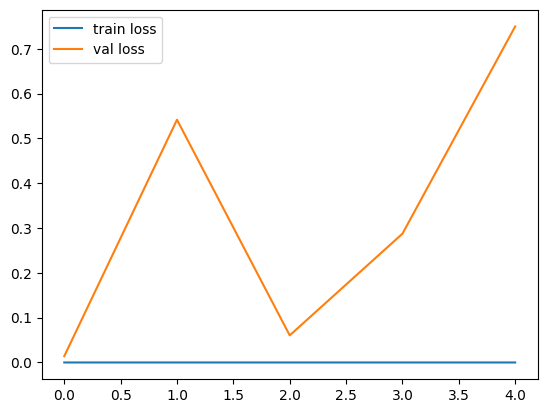

In [ ]:
import matplotlib.pyplot as plt
#plot train and val loss
plt.plot(tr_loss_per_epoch, label='train loss')
plt.plot(val_loss_per_epoch, label='val loss')
plt.legend()
plt.show()


In [68]:
# normals extraction

norm_files = np.load('normals_files.npy')
normals = []
for file in norm_files:
    normals.append(np.loadtxt(file))

In [69]:
normals = np.array(normals)
normals.shape

(381, 100000, 3)

In [71]:
x = np.load('origianl_normals.npy')

In [72]:
x.shape

(381, 100000, 3)